In [557]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns
import sqlite3
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

import hdbscan


from tsne_plot import *

%matplotlib inline

In [464]:
# Data from sql file on kaggle https://www.kaggle.com/gabrio/board-games-dataset

# Pickled for git hub, no longer! We just path to it

conn = sqlite3.connect('../database.sqlite 2')

df_raw = pd.read_sql_query('SELECT * FROM BoardGames', conn)

conn.close()

In [3]:
# df_raw.to_pickle('./raw_df.pkl')
# df_raw = pd.read_pickle('./raw_df.pkl')

In [4]:
pd.set_option('display.max_columns', 999)
df_raw.sort_values(by = ['stats.average'], ascending=False).head()

,row_names,game.id,game.type,details.description,details.image,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.name,details.playingtime,details.thumbnail,details.yearpublished,attributes.boardgameartist,attributes.boardgamecategory,attributes.boardgamecompilation,attributes.boardgamedesigner,attributes.boardgameexpansion,attributes.boardgamefamily,attributes.boardgameimplementation,attributes.boardgameintegration,attributes.boardgamemechanic,attributes.boardgamepublisher,attributes.total,stats.average,stats.averageweight,stats.bayesaverage,stats.family.abstracts.bayesaverage,stats.family.abstracts.pos,stats.family.cgs.bayesaverage,stats.family.cgs.pos,stats.family.childrensgames.bayesaverage,stats.family.childrensgames.pos,stats.family.familygames.bayesaverage,stats.family.familygames.pos,stats.family.partygames.bayesaverage,stats.family.partygames.pos,stats.family.strategygames.bayesaverage,stats.family.strategygames.pos,stats.family.thematic.bayesaverage,stats.family.thematic.pos,stats.family.wargames.bayesaverage,stats.family.wargames.pos,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.subtype.boardgame.bayesaverage,stats.subtype.boardgame.pos,stats.trading,stats.usersrated,stats.wanting,stats.wishing,polls.language_dependence,polls.suggested_numplayers.1,polls.suggested_numplayers.10,polls.suggested_numplayers.2,polls.suggested_numplayers.3,polls.suggested_numplayers.4,polls.suggested_numplayers.5,polls.suggested_numplayers.6,polls.suggested_numplayers.7,polls.suggested_numplayers.8,polls.suggested_numplayers.9,polls.suggested_numplayers.Over,polls.suggested_playerage,attributes.t.links.concat.2....,stats.family.amiga.bayesaverage,stats.family.amiga.pos,stats.family.arcade.bayesaverage,stats.family.arcade.pos,stats.family.atarist.bayesaverage,stats.family.atarist.pos,stats.family.commodore64.bayesaverage,stats.family.commodore64.pos,stats.subtype.rpgitem.bayesaverage,stats.subtype.rpgitem.pos,stats.subtype.videogame.bayesaverage,stats.subtype.videogame.pos
88590,88591,213296,boardgame,"Meu Jardim (My Garden, in Portuguese) is a til...",//cf.geekdo-images.com/images/pic3291166.jpg,4.0,30.0,4.0,1.0,10.0,Meu Jardim,30.0,//cf.geekdo-images.com/images/pic3291166_t.jpg,2016.0,Luiza Sequeira,"Children's Game,Puzzle",None,Rafael Arrivabene,None,None,None,None,"Pattern Recognition,Tile Placement",Ludens Spirit,5.0,10.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,0.0,NaN,NaN,0.0,1.0,0.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85161,85162,220661,boardgame,Description from the publisher:&#10;&#10;Genso...,//cf.geekdo-images.com/images/pic3446081.jpg,2.0,30.0,0.0,2.0,30.0,Genso Suikoden Card Stories Trading Card Game,30.0,//cf.geekdo-images.com/images/pic3446081_t.jpg,2001.0,None,"Card Game,Collectible Components,Math,Video Ga...",None,None,None,CCGs (Collectible Card Games),None,None,Hand Management,Konami,4.0,10.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,1.0,0.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90072,90073,219140,boardgameexpansion,"Since 1943 the ISU format, a heavy self-propel...",//cf.geekdo-images.com/images/pic3426277.jpg,2.0,0.0,0.0,2.0,0.0,"Dust Tactics: ISU-203 Heavy Assault Gun – ""Ser...",0.0,//cf.geekdo-images.com/images/pic3426277_t.jpg,0.0,Paolo Parente,"Miniatures,Science Fiction,World War II",None,Paolo Parente,"Dust 1947,Dust Tactics,Dust Tactics: Revised C...",Dust,None,None,"Action Point Allowance System,Dice Rolling,Mod...",Dust Studio,7.0,10.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,0.0,1.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 81 columns):
row_names                                   90400 non-null object
game.id                                     90400 non-null object
game.type                                   90400 non-null object
details.description                         90400 non-null object
details.image                               83508 non-null object
details.maxplayers                          90397 non-null float64
details.maxplaytime                         90397 non-null float64
details.minage                              90397 non-null float64
details.minplayers                          90397 non-null float64
details.minplaytime                         90397 non-null float64
details.name                                90400 non-null object
details.playingtime                         90397 non-null float64
details.thumbnail                           83508 non-null object
details.yearpublished      

In [6]:
df_raw['attributes.boardgamedesigner'].value_counts()

(Uncredited)                                             18729
Lloyd Krassner                                             765
Reiner Knizia                                              493
Charles Darrow                                             246
Michael Schacht                                            205
                                                         ...  
Richard Keene                                                1
Rowe Cavelli                                                 1
Mike Elliott,Rob Heinsoo,Brian Tinsman,Jonathan Tweet        1
Alan Holmes                                                  1
Steve Mainprize                                              1
Name: attributes.boardgamedesigner, Length: 22699, dtype: int64

In [7]:
non_null_col = []

for col in df_raw.columns:
    if df_raw[col].isnull().sum() < 30000:
        non_null_col.append(col)

In [8]:
df_raw[non_null_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 31 columns):
row_names                        90400 non-null object
game.id                          90400 non-null object
game.type                        90400 non-null object
details.description              90400 non-null object
details.image                    83508 non-null object
details.maxplayers               90397 non-null float64
details.maxplaytime              90397 non-null float64
details.minage                   90397 non-null float64
details.minplayers               90397 non-null float64
details.minplaytime              90397 non-null float64
details.name                     90400 non-null object
details.playingtime              90397 non-null float64
details.thumbnail                83508 non-null object
details.yearpublished            90397 non-null float64
attributes.boardgamecategory     88869 non-null object
attributes.boardgamedesigner     78517 non-null object
attr

In [9]:
df_raw[non_null_col]

,row_names,game.id,game.type,details.description,details.image,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.name,details.playingtime,details.thumbnail,details.yearpublished,attributes.boardgamecategory,attributes.boardgamedesigner,attributes.boardgamemechanic,attributes.boardgamepublisher,attributes.total,stats.average,stats.averageweight,stats.bayesaverage,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.trading,stats.usersrated,stats.wanting,stats.wishing
0,1,1,boardgame,Die Macher is a game about seven sequential po...,//cf.geekdo-images.com/images/pic159509.jpg,5.0,240.0,14.0,3.0,240.0,Die Macher,240.0,//cf.geekdo-images.com/images/pic159509_t.jpg,1986.0,"Economic,Negotiation,Political",Karl-Heinz Schmiel,"Area Control / Area Influence,Auction/Bidding,...","Hans im Glück Verlags-GmbH,Moskito Spiele,Vall...",6.0,7.66508,4.3477,7.29168,0.0,1763.0,719.0,5251.0,1.59321,170.0,4498.0,505.0,1654.0
1,2,2,boardgame,Dragonmaster is a trick-taking card game based...,//cf.geekdo-images.com/images/pic184174.jpg,4.0,30.0,12.0,3.0,30.0,Dragonmaster,30.0,//cf.geekdo-images.com/images/pic184174_t.jpg,1981.0,"Card Game,Fantasy","G. W. ""Jerry"" D'Arcey",Trick-taking,"E.S. Lowe,Milton Bradley",7.0,6.60815,1.9423,5.87150,0.0,273.0,52.0,1053.0,1.46282,73.0,478.0,67.0,161.0
2,3,3,boardgame,"Part of the Knizia tile-laying trilogy, Samura...",//cf.geekdo-images.com/images/pic3211873.jpg,4.0,60.0,10.0,2.0,30.0,Samurai,60.0,//cf.geekdo-images.com/images/pic3211873_t.jpg,1998.0,"Abstract Strategy,Medieval",Reiner Knizia,"Area Control / Area Influence,Hand Management,...","999 Games,ABACUSSPIELE,Astrel Games,Ceilikan J...",6.0,7.44119,2.5085,7.28295,0.0,3281.0,1355.0,11870.0,1.18531,234.0,12019.0,707.0,2601.0
3,4,4,boardgame,When you see the triangular box and the luxuri...,//cf.geekdo-images.com/images/pic285299.jpg,4.0,60.0,12.0,2.0,60.0,Tal der Könige,60.0,//cf.geekdo-images.com/images/pic285299_t.jpg,1992.0,Ancient,Christian Beierer,"Action Point Allowance System,Area Control / A...",KOSMOS,5.0,6.60675,2.6667,5.76636,0.0,111.0,30.0,523.0,1.21028,29.0,314.0,61.0,112.0
4,5,5,boardgame,"In Acquire, each player strategically invests ...",//cf.geekdo-images.com/images/pic342163.jpg,6.0,90.0,12.0,3.0,90.0,Acquire,90.0,//cf.geekdo-images.com/images/pic342163_t.jpg,1964.0,Economic,Sid Sackson,"Hand Management,Stock Holding,Tile Placement","3M,Avalon Hill,Avalon Hill (Hasbro),Dujardin,G...",6.0,7.35830,2.5089,7.21895,0.0,5011.0,1515.0,18682.0,1.33020,823.0,15195.0,516.0,2219.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90395,90396,220053,boardgame,Soldier Ball is a tabletop skill and strategy ...,//cf.geekdo-images.com/images/pic3436079.jpg,2.0,15.0,4.0,2.0,5.0,Soldier Ball,15.0,//cf.geekdo-images.com/images/pic3436079_t.jpg,2016.0,Action / Dexterity,Nate Dallas,None,(Self-Published),4.0,8.00000,1.0000,0.00000,0.0,3.0,1.0,3.0,0.00000,0.0,3.0,0.0,0.0
90396,90397,220055,boardgame,Description from the designer:&#10;&#10;The ye...,//cf.geekdo-images.com/images/pic3529002.jpg,4.0,45.0,14.0,2.0,30.0,Habeamus,45.0,//cf.geekdo-images.com/images/pic3529002_t.jpg,2017.0,"Bluffing,Card Game,Negotiation,Religious,Renai...","Simon Schliesky,Johannes Spielmann","Auction/Bidding,Hand Management,Trading",(Self-Published),6.0,8.00000,0.0000,0.00000,0.0,1.0,0.0,0.0,0.00000,0.0,1.0,0.0,0.0
90397,90398,220068,boardgameexpansion,Cecrops founded Athens and judged a competitio...,//cf.geekdo-images.com/images/pic3503602.jpg,4.0,90.0,14.0,1.0,45.0,Mythic Battles: Pantheon – Cecrops,90.0,//cf.geekdo-images.com/images/pic3503602_t.jpg,2017.0,"Ancient,Card Game,Dice,Expansion for Base-game...",Benoit Vogt,"Area Movement,Campaign / Battle Card Driven,Ca...","Monolith,Mythic Games",7.0,10.00000,0.0000,0.00000,0.0,3.0,0.0,9.0,0.00000,0.0,1.0,0.0,3.0
90398,90399,220069,boardgameexpansion,"The famous Myrmidons are the 

In [10]:
df_raw['attributes.boardgamemechanic'].value_counts()

Roll / Spin and Move                                                                                                                                 6833
Dice Rolling                                                                                                                                         3998
Hex-and-Counter                                                                                                                                      3281
Hand Management                                                                                                                                      1858
Set Collection                                                                                                                                       1648
                                                                                                                                                     ... 
Area Control / Area Influence,Campaign / Battle Card Driven,Deck / Pool Buil

In [11]:
mechanics_sub = [f"{x}".split(',') for x in df_raw['attributes.boardgamemechanic']]

In [12]:
mechanics_list = [val for sublist in mechanics_sub for val in sublist]

In [13]:
mechanics_unq_list = list(set(mechanics_list))

In [14]:
mech_dic = sorted([(x,mechanics_list.count(x)) for x in mechanics_unq_list], key=lambda x : x[1], reverse=True);

In [15]:
mech_dic

[('Dice Rolling', 20485),
 ('None', 15237),
 ('Roll / Spin and Move', 13812),
 ('Hand Management', 11068),
 ('Set Collection', 9202),
 ('Variable Player Powers', 7318),
 ('Hex-and-Counter', 6712),
 ('Card Drafting', 6120),
 ('Tile Placement', 4823),
 ('Modular Board', 4628),
 ('Co-operative Play', 4393),
 ('Simulation', 3932),
 ('Memory', 3883),
 ('Point to Point Movement', 3860),
 ('Simultaneous Action Selection', 3590),
 ('Action Point Allowance System', 3499),
 ('Area Control / Area Influence', 3317),
 ('Trading', 3229),
 ('Auction/Bidding', 3228),
 ('Area Movement', 3087),
 ('Grid Movement', 2589),
 ('Pattern Building', 2362),
 ('Partnerships', 2290),
 ('Pattern Recognition', 2218),
 ('Role Playing', 2116),
 ('Deck / Pool Building', 1968),
 ('Pick-up and Deliver', 1774),
 ('Player Elimination', 1718),
 ('Campaign / Battle Card Driven', 1714),
 ('Storytelling', 1601),
 ('Betting/Wagering', 1569),
 ('Press Your Luck', 1567),
 ('Secret Unit Deployment', 1546),
 ('Take That', 1419),
 (

In [16]:
df_raw.loc[df_raw['attributes.boardgamemechanic'].isna()].head(2)

,row_names,game.id,game.type,details.description,details.image,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.name,details.playingtime,details.thumbnail,details.yearpublished,attributes.boardgameartist,attributes.boardgamecategory,attributes.boardgamecompilation,attributes.boardgamedesigner,attributes.boardgameexpansion,attributes.boardgamefamily,attributes.boardgameimplementation,attributes.boardgameintegration,attributes.boardgamemechanic,attributes.boardgamepublisher,attributes.total,stats.average,stats.averageweight,stats.bayesaverage,stats.family.abstracts.bayesaverage,stats.family.abstracts.pos,stats.family.cgs.bayesaverage,stats.family.cgs.pos,stats.family.childrensgames.bayesaverage,stats.family.childrensgames.pos,stats.family.familygames.bayesaverage,stats.family.familygames.pos,stats.family.partygames.bayesaverage,stats.family.partygames.pos,stats.family.strategygames.bayesaverage,stats.family.strategygames.pos,stats.family.thematic.bayesaverage,stats.family.thematic.pos,stats.family.wargames.bayesaverage,stats.family.wargames.pos,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.subtype.boardgame.bayesaverage,stats.subtype.boardgame.pos,stats.trading,stats.usersrated,stats.wanting,stats.wishing,polls.language_dependence,polls.suggested_numplayers.1,polls.suggested_numplayers.10,polls.suggested_numplayers.2,polls.suggested_numplayers.3,polls.suggested_numplayers.4,polls.suggested_numplayers.5,polls.suggested_numplayers.6,polls.suggested_numplayers.7,polls.suggested_numplayers.8,polls.suggested_numplayers.9,polls.suggested_numplayers.Over,polls.suggested_playerage,attributes.t.links.concat.2....,stats.family.amiga.bayesaverage,stats.family.amiga.pos,stats.family.arcade.bayesaverage,stats.family.arcade.pos,stats.family.atarist.bayesaverage,stats.family.atarist.pos,stats.family.commodore64.bayesaverage,stats.family.commodore64.pos,stats.subtype.rpgitem.bayesaverage,stats.subtype.rpgitem.pos,stats.subtype.videogame.bayesaverage,stats.subtype.videogame.pos
20,21,21,boardgame,"A 4X game (eXplore, eXpand, eXploit, eXtermina...",//cf.geekdo-images.com/images/pic1615146.jpg,7.0,0.0,12.0,1.0,0.0,Gateway to the Stars,0.0,//cf.geekdo-images.com/images/pic1615146_t.jpg,1981.0,None,"Civilization,Exploration,Science Fiction",None,Mark A. Snowden,None,4X games,None,None,None,Twentieth Century Renaissance,4.0,5.35714,3.0000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,18.0,5.0,80.0,1.67362,NaN,NaN,4.0,28.0,1.0,11.0,Moderate,Recommended,None,Recommended,NotRecommended,Recommended,Recommended,Recommended,Recommended,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,25,25,boardgame,"In this fantasy sequel to Twilight Imperium, p...",//cf.geekdo-images.com/images/pic10146.jpg,6.0,200.0,12.0,2.0,200.0,Battlemist,200.0,//cf.geekdo-images.com/images/pic10146_t.jpg,1998.0,"Bill Heagy,Christian T. Petersen","Exploration,Fantasy,Wargame",None,Christian T. Petersen,Battlemist: The Sails of War,"4X games,The Realms of Terrinoth",Runewars,None,None,Fantasy Flight Games,7.0,5.93231,3.2105,5.58913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6472,682.0,5.73762,1715.0,0.0,138.0,19.0,622.0,1.48755,5.58913,5930.0,68.0,308.0,17.0,49.0,None,NotRecommended,None,NotRecommended,Recommended,Recommended,Recommended,NotRecommended,None,None,None,NotRecommended,12,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Drop games with no mechanics

df_raw.dropna(subset=['attributes.boardgamemechanic'], inplace=True)

In [18]:
df_raw['game.type'].value_counts()

boardgame             62971
boardgameexpansion    12192
Name: game.type, dtype: int64

In [19]:
# Keep only games that are boardgames in their own right
# Keep only games that have more than 5 votes

df_raw = df_raw.loc[df_raw['game.type'] != 'boardgameexpansion']
df_raw = df_raw.loc[df_raw['stats.usersrated'] > 5]

In [20]:
df_raw

,row_names,game.id,game.type,details.description,details.image,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.name,details.playingtime,details.thumbnail,details.yearpublished,attributes.boardgameartist,attributes.boardgamecategory,attributes.boardgamecompilation,attributes.boardgamedesigner,attributes.boardgameexpansion,attributes.boardgamefamily,attributes.boardgameimplementation,attributes.boardgameintegration,attributes.boardgamemechanic,attributes.boardgamepublisher,attributes.total,stats.average,stats.averageweight,stats.bayesaverage,stats.family.abstracts.bayesaverage,stats.family.abstracts.pos,stats.family.cgs.bayesaverage,stats.family.cgs.pos,stats.family.childrensgames.bayesaverage,stats.family.childrensgames.pos,stats.family.familygames.bayesaverage,stats.family.familygames.pos,stats.family.partygames.bayesaverage,stats.family.partygames.pos,stats.family.strategygames.bayesaverage,stats.family.strategygames.pos,stats.family.thematic.bayesaverage,stats.family.thematic.pos,stats.family.wargames.bayesaverage,stats.family.wargames.pos,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.subtype.boardgame.bayesaverage,stats.subtype.boardgame.pos,stats.trading,stats.usersrated,stats.wanting,stats.wishing,polls.language_dependence,polls.suggested_numplayers.1,polls.suggested_numplayers.10,polls.suggested_numplayers.2,polls.suggested_numplayers.3,polls.suggested_numplayers.4,polls.suggested_numplayers.5,polls.suggested_numplayers.6,polls.suggested_numplayers.7,polls.suggested_numplayers.8,polls.suggested_numplayers.9,polls.suggested_numplayers.Over,polls.suggested_playerage,attributes.t.links.concat.2....,stats.family.amiga.bayesaverage,stats.family.amiga.pos,stats.family.arcade.bayesaverage,stats.family.arcade.pos,stats.family.atarist.bayesaverage,stats.family.atarist.pos,stats.family.commodore64.bayesaverage,stats.family.commodore64.pos,stats.subtype.rpgitem.bayesaverage,stats.subtype.rpgitem.pos,stats.subtype.videogame.bayesaverage,stats.subtype.videogame.pos
0,1,1,boardgame,Die Macher is a game about seven sequential po...,//cf.geekdo-images.com/images/pic159509.jpg,5.0,240.0,14.0,3.0,240.0,Die Macher,240.0,//cf.geekdo-images.com/images/pic159509_t.jpg,1986.0,Marcus Gschwendtner,"Economic,Negotiation,Political",None,Karl-Heinz Schmiel,None,"Country: Germany,Valley Games Classic Line",None,None,"Area Control / Area Influence,Auction/Bidding,...","Hans im Glück Verlags-GmbH,Moskito Spiele,Vall...",6.0,7.66508,4.3477,7.29168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.39570,85.0,NaN,NaN,NaN,NaN,0.0,1763.0,719.0,5251.0,1.59321,7.29168,147.0,170.0,4498.0,505.0,1654.0,No,NotRecommended,None,NotRecommended,NotRecommended,Recommended,Best,None,None,None,None,NotRecommended,14,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,boardgame,Dragonmaster is a trick-taking card game based...,//cf.geekdo-images.com/images/pic184174.jpg,4.0,30.0,12.0,3.0,30.0,Dragonmaster,30.0,//cf.geekdo-images.com/images/pic184174_t.jpg,1981.0,Bob Pepper,"Card Game,Fantasy",None,"G. W. ""Jerry"" D'Arcey",None,Animals: Dragons,"Indulgence,Coup d'etat",None,Trick-taking,"E.S. Lowe,Milton Bradley",7.0,6.60815,1.9423,5.87150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.91318,1066.0,NaN,NaN,NaN,NaN,0.0,273.0,52.0,1053.0,1.46282,5.87150,2541.0,73.0,478.0,67.0,161.0,Some,NotRecommended,None,NotRecommended,Recommended,Best,None,None,None,None,None,NotRecommended,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3,boardgame,"Part of the Knizia tile-laying trilogy, Samura...",//cf.geekdo-images.com/images/pic3211873.jpg,4.0,60.0,10.0,2.0,30.0,Samurai,60.0,//cf.geekdo-images.com/images/pic3211873_t.jpg,1998.0,Franz Vohwinkel,"Abstract Strategy,Medieval",None,Reiner Knizia,None,"Asian Theme,Country: Japan,Knizia tile-laying ...",None,None,"Area Control / Area Influence,Hand Management,...","999 Games,ABACUSSPIELE,Astrel Games,Ceilikan J...",6.0,7.44119,2.5085,7.28295,NaN

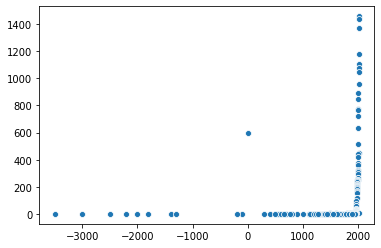

In [21]:
sns.scatterplot(data = df_raw['details.yearpublished'].value_counts())

In [22]:
df_raw['details.yearpublished'].value_counts()

2015.0    1456
2016.0    1436
2014.0    1370
2013.0    1177
2012.0    1105
          ... 
1944.0       1
650.0        1
1883.0       1
1430.0       1
1550.0       1
Name: details.yearpublished, Length: 207, dtype: int64

In [23]:
df_raw.loc[df_raw['details.yearpublished'] == 650]

,row_names,game.id,game.type,details.description,details.image,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.name,details.playingtime,details.thumbnail,details.yearpublished,attributes.boardgameartist,attributes.boardgamecategory,attributes.boardgamecompilation,attributes.boardgamedesigner,attributes.boardgameexpansion,attributes.boardgamefamily,attributes.boardgameimplementation,attributes.boardgameintegration,attributes.boardgamemechanic,attributes.boardgamepublisher,attributes.total,stats.average,stats.averageweight,stats.bayesaverage,stats.family.abstracts.bayesaverage,stats.family.abstracts.pos,stats.family.cgs.bayesaverage,stats.family.cgs.pos,stats.family.childrensgames.bayesaverage,stats.family.childrensgames.pos,stats.family.familygames.bayesaverage,stats.family.familygames.pos,stats.family.partygames.bayesaverage,stats.family.partygames.pos,stats.family.strategygames.bayesaverage,stats.family.strategygames.pos,stats.family.thematic.bayesaverage,stats.family.thematic.pos,stats.family.wargames.bayesaverage,stats.family.wargames.pos,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.subtype.boardgame.bayesaverage,stats.subtype.boardgame.pos,stats.trading,stats.usersrated,stats.wanting,stats.wishing,polls.language_dependence,polls.suggested_numplayers.1,polls.suggested_numplayers.10,polls.suggested_numplayers.2,polls.suggested_numplayers.3,polls.suggested_numplayers.4,polls.suggested_numplayers.5,polls.suggested_numplayers.6,polls.suggested_numplayers.7,polls.suggested_numplayers.8,polls.suggested_numplayers.9,polls.suggested_numplayers.Over,polls.suggested_playerage,attributes.t.links.concat.2....,stats.family.amiga.bayesaverage,stats.family.amiga.pos,stats.family.arcade.bayesaverage,stats.family.arcade.pos,stats.family.atarist.bayesaverage,stats.family.atarist.pos,stats.family.commodore64.bayesaverage,stats.family.commodore64.pos,stats.subtype.rpgitem.bayesaverage,stats.subtype.rpgitem.pos,stats.subtype.videogame.bayesaverage,stats.subtype.videogame.pos
16581,16582,18011,boardgame,"Published in GAMES Magazine, January/February ...",//cf.geekdo-images.com/images/pic184346.jpg,4.0,30.0,8.0,2.0,30.0,Chaturanga,30.0,//cf.geekdo-images.com/images/pic184346_t.jpg,650.0,None,Abstract Strategy,None,(Uncredited),None,Chess Games,None,None,"Dice Rolling,Grid Movement,Player Elimination","(Public Domain),ABRA,Aztral Games,Front Porch ...",5.0,6.02625,2.2667,5.53479,5.62354,531.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,48.0,15.0,241.0,1.28197,5.53479,8669.0,19.0,80.0,9.0,45.0,No,NotRecommended,None,Recommended,NotRecommended,Best,None,None,None,None,None,NotRecommended,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_raw.loc[df_raw['game.id'] == '1']

,row_names,game.id,game.type,details.description,details.image,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.name,details.playingtime,details.thumbnail,details.yearpublished,attributes.boardgameartist,attributes.boardgamecategory,attributes.boardgamecompilation,attributes.boardgamedesigner,attributes.boardgameexpansion,attributes.boardgamefamily,attributes.boardgameimplementation,attributes.boardgameintegration,attributes.boardgamemechanic,attributes.boardgamepublisher,attributes.total,stats.average,stats.averageweight,stats.bayesaverage,stats.family.abstracts.bayesaverage,stats.family.abstracts.pos,stats.family.cgs.bayesaverage,stats.family.cgs.pos,stats.family.childrensgames.bayesaverage,stats.family.childrensgames.pos,stats.family.familygames.bayesaverage,stats.family.familygames.pos,stats.family.partygames.bayesaverage,stats.family.partygames.pos,stats.family.strategygames.bayesaverage,stats.family.strategygames.pos,stats.family.thematic.bayesaverage,stats.family.thematic.pos,stats.family.wargames.bayesaverage,stats.family.wargames.pos,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.subtype.boardgame.bayesaverage,stats.subtype.boardgame.pos,stats.trading,stats.usersrated,stats.wanting,stats.wishing,polls.language_dependence,polls.suggested_numplayers.1,polls.suggested_numplayers.10,polls.suggested_numplayers.2,polls.suggested_numplayers.3,polls.suggested_numplayers.4,polls.suggested_numplayers.5,polls.suggested_numplayers.6,polls.suggested_numplayers.7,polls.suggested_numplayers.8,polls.suggested_numplayers.9,polls.suggested_numplayers.Over,polls.suggested_playerage,attributes.t.links.concat.2....,stats.family.amiga.bayesaverage,stats.family.amiga.pos,stats.family.arcade.bayesaverage,stats.family.arcade.pos,stats.family.atarist.bayesaverage,stats.family.atarist.pos,stats.family.commodore64.bayesaverage,stats.family.commodore64.pos,stats.subtype.rpgitem.bayesaverage,stats.subtype.rpgitem.pos,stats.subtype.videogame.bayesaverage,stats.subtype.videogame.pos
0,1,1,boardgame,Die Macher is a game about seven sequential po...,//cf.geekdo-images.com/images/pic159509.jpg,5.0,240.0,14.0,3.0,240.0,Die Macher,240.0,//cf.geekdo-images.com/images/pic159509_t.jpg,1986.0,Marcus Gschwendtner,"Economic,Negotiation,Political",None,Karl-Heinz Schmiel,None,"Country: Germany,Valley Games Classic Line",None,None,"Area Control / Area Influence,Auction/Bidding,...","Hans im Glück Verlags-GmbH,Moskito Spiele,Vall...",6.0,7.66508,4.3477,7.29168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.3957,85.0,NaN,NaN,NaN,NaN,0.0,1763.0,719.0,5251.0,1.59321,7.29168,147.0,170.0,4498.0,505.0,1654.0,No,NotRecommended,None,NotRecommended,NotRecommended,Recommended,Best,None,None,None,None,NotRecommended,14,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_raw['game.id']

0             1
1             2
2             3
3             4
4             5
          ...  
90239    219513
90277    219666
90327    219774
90334    219807
90341    219832
Name: game.id, Length: 23902, dtype: object

In [26]:
# ids = [x for x in df_raw['game.id']]
# ids = list(set(ids))
# with open('ids.txt', 'w') as f:
#     f.write('\n'.join(ids))

In [27]:
df_scrape = pd.DataFrame(pd.read_csv('games.csv'))

In [28]:
df_scrape = df_scrape.set_index('id').drop(columns=['type'])

In [29]:
# Remove the weird b at the start of all the elements
df_scrape = df_scrape.applymap(lambda x : x[2:-1])

In [30]:
df_raw.rename(columns={'game.id' : 'id'}, inplace=True)

In [31]:
df_raw = df_raw.astype({'id': 'int64'});

In [32]:
df_raw['id'].dtype

dtype('int64')

In [33]:
df_join = df_raw.join(df_scrape, on='id')

In [34]:
df_art = df_join[['id','details.name','details.description','attributes.boardgameartist', 'attributes.boardgamedesigner']]

In [35]:
df_join.drop(columns=['row_names', 'game.type', 'details.image', 'details.thumbnail', 'details.yearpublished','attributes.boardgamecompilation',
                      'attributes.boardgameexpansion', 'attributes.boardgameimplementation', 'attributes.boardgameintegration',
                      'attributes.total', 'stats.average', 'stats.averageweight','stats.bayesaverage', 'stats.median', 'stats.numcomments',
                      'stats.numweights', 'stats.owned', 'stats.stddev','stats.subtype.boardgame.bayesaverage', 'stats.subtype.boardgame.pos',
                      'stats.trading', 'stats.usersrated', 'stats.wanting', 'stats.wishing', 'attributes.t.links.concat.2....', 'name', 'stats.family.amiga.bayesaverage', 'stats.family.amiga.pos',
                      'stats.family.arcade.bayesaverage', 'stats.family.arcade.pos','stats.family.atarist.bayesaverage', 'stats.family.atarist.pos',
                       'stats.family.commodore64.bayesaverage', 'stats.family.commodore64.pos',
                       'stats.subtype.rpgitem.bayesaverage', 'stats.subtype.rpgitem.pos',
                       'stats.subtype.videogame.bayesaverage', 'stats.subtype.videogame.pos',
                      'polls.suggested_numplayers.1', 'polls.suggested_numplayers.10', 'polls.suggested_numplayers.2', 'polls.suggested_numplayers.3',
                      'polls.suggested_numplayers.4','polls.suggested_numplayers.5','polls.suggested_numplayers.6','polls.suggested_numplayers.7',
                      'polls.suggested_numplayers.8', 'polls.suggested_numplayers.9','polls.suggested_numplayers.Over',
                      'stats.family.abstracts.bayesaverage', 'stats.family.abstracts.pos',
                      'stats.family.cgs.bayesaverage', 'stats.family.cgs.pos',
                      'stats.family.childrensgames.bayesaverage',
                      'stats.family.childrensgames.pos',
                      'stats.family.familygames.bayesaverage', 'stats.family.familygames.pos',
                      'stats.family.partygames.bayesaverage', 'stats.family.partygames.pos',
                      'stats.family.strategygames.bayesaverage',
                      'stats.family.strategygames.pos', 'stats.family.thematic.bayesaverage',
                      'stats.family.thematic.pos', 'stats.family.wargames.bayesaverage',
                      'stats.family.wargames.pos', 'details.maxplaytime', 'details.minplaytime','total_owners', 'total_traders',
                      'total_wanters', 'total_wishers', 'total_comments', 'minage', 'minplaytime', 'maxplaytime', 'polls.suggested_playerage',
                      'polls.language_dependence', 'details.playingtime', 'details.minplayers', 'details.minage', 'details.maxplayers', 'attributes.boardgamefamily',
                      'attributes.boardgamedesigner', 'attributes.boardgamepublisher', 'attributes.boardgameartist', 'details.description'
                    ], inplace=True)
df_join

,id,details.name,attributes.boardgamecategory,attributes.boardgamemechanic,yearpublished,minplayers,maxplayers,playingtime,users_rated,average_rating,bayes_average_rating,total_weights,average_weight
0,1,Die Macher,"Economic,Negotiation,Political","Area Control / Area Influence,Auction/Bidding,...",1986,3,5,240,4900,7.6229,7.1591,737,4.3433
1,2,Dragonmaster,"Card Game,Fantasy",Trick-taking,1981,3,4,30,531,6.60562,5.81019,54,1.963
2,3,Samurai,"Abstract Strategy,Medieval","Area Control / Area Influence,Hand Management,...",1998,2,4,60,13903,7.44307,7.25092,1415,2.4961
3,4,Tal der Könige,Ancient,"Action Point Allowance System,Area Control / A...",1992,2,4,60,327,6.60924,5.7078,30,2.6667
4,5,Acquire,Economic,"Hand Management,Stock Holding,Tile Placement",1964,2,6,90,17439,7.34797,7.17366,1572,2.5057
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90239,219513,Bärenpark,"Animals,Puzzle",Tile Placement,2017,2,4,45,8708,7.35728,7.08617,170,1.6882
90277,219666,Ciudad de Cartón,City Building,"Auction/Bidding,Dice Rolling,Trading",2017,2,5,50,35,8.98571,5.51144,2,1
90327,219774,Vikings Gone Wild Ultimate Set,"Card Game,Fantasy,Humor,Medieval,Mythology","Deck / Pool Building,Hand Management",2017,2,5,70,112,7.84652,5.65395,2,3
90334,219807,Test of Honour: The Samurai Miniatures Game,"Medieval,Miniatures,Wargame","Campaign / Battle Card Driven,Dice Rolling",2017,2,4,60,84,7.85952,5.60058,3,2


In [36]:
df_join = df_join.loc[~df_join['average_weight'].isna()]

In [37]:
df_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23881 entries, 0 to 90341
Data columns (total 13 columns):
id                              23881 non-null int64
details.name                    23881 non-null object
attributes.boardgamecategory    23646 non-null object
attributes.boardgamemechanic    23881 non-null object
yearpublished                   23881 non-null object
minplayers                      23881 non-null object
maxplayers                      23881 non-null object
playingtime                     23881 non-null object
users_rated                     23881 non-null object
average_rating                  23881 non-null object
bayes_average_rating            23881 non-null object
total_weights                   23881 non-null object
average_weight                  23881 non-null object
dtypes: int64(1), object(12)
memory usage: 2.6+ MB


In [38]:
# Finally we have a full dataframe with all the relavent bits
# This will be split into a dataframe for the t-SNE by one-hot'ing the mechanics
# Sadly this join only gives us up to date voting stats on games that we had the mechanics for back in 2017
# Means that some modern classics such as TI:4th edd are excluded

df_join

,id,details.name,attributes.boardgamecategory,attributes.boardgamemechanic,yearpublished,minplayers,maxplayers,playingtime,users_rated,average_rating,bayes_average_rating,total_weights,average_weight
0,1,Die Macher,"Economic,Negotiation,Political","Area Control / Area Influence,Auction/Bidding,...",1986,3,5,240,4900,7.6229,7.1591,737,4.3433
1,2,Dragonmaster,"Card Game,Fantasy",Trick-taking,1981,3,4,30,531,6.60562,5.81019,54,1.963
2,3,Samurai,"Abstract Strategy,Medieval","Area Control / Area Influence,Hand Management,...",1998,2,4,60,13903,7.44307,7.25092,1415,2.4961
3,4,Tal der Könige,Ancient,"Action Point Allowance System,Area Control / A...",1992,2,4,60,327,6.60924,5.7078,30,2.6667
4,5,Acquire,Economic,"Hand Management,Stock Holding,Tile Placement",1964,2,6,90,17439,7.34797,7.17366,1572,2.5057
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90239,219513,Bärenpark,"Animals,Puzzle",Tile Placement,2017,2,4,45,8708,7.35728,7.08617,170,1.6882
90277,219666,Ciudad de Cartón,City Building,"Auction/Bidding,Dice Rolling,Trading",2017,2,5,50,35,8.98571,5.51144,2,1
90327,219774,Vikings Gone Wild Ultimate Set,"Card Game,Fantasy,Humor,Medieval,Mythology","Deck / Pool Building,Hand Management",2017,2,5,70,112,7.84652,5.65395,2,3
90334,219807,Test of Honour: The Samurai Miniatures Game,"Medieval,Miniatures,Wargame","Campaign / Battle Card Driven,Dice Rolling",2017,2,4,60,84,7.85952,5.60058,3,2


In [39]:
df_tsne = df_join

In [40]:
categories_sub = [f"{x}".split(',') for x in df_raw['attributes.boardgamecategory']]

In [41]:
categories_list = [val for sublist in categories_sub for val in sublist]

In [64]:
categories_unq_list = list(set(categories_list))
categories_unq_list.remove('None')

In [43]:
df_tsne = pd.concat([df_tsne, pd.DataFrame(columns=categories_unq_list)], sort=False)

In [44]:
df_tsne = pd.concat([df_tsne, pd.DataFrame(columns=mechanics_unq_list)], sort=False)

In [66]:
# Remove games with no category
df_tsne = df_tsne.loc[~df_tsne['attributes.boardgamecategory'].isna()]

In [67]:
df_tsne.head()

,id,details.name,attributes.boardgamecategory,attributes.boardgamemechanic,yearpublished,minplayers,maxplayers,playingtime,users_rated,average_rating,bayes_average_rating,total_weights,average_weight,Political,Mafia,Fighting,Action / Dexterity,Farming,Negotiation,American West,Memory,World War II,Economic,Horror,Real-time,American Revolutionary War,Racing,Korean War,Abstract Strategy,Modern Warfare,Vietnam War,Environmental,American Indian Wars,Number,Fantasy,Deduction,Civil War,Mature / Adult,Prehistoric,Card Game,Ancient,Miniatures,Educational,Collectible Components,Word Game,Science Fiction,Dice,World War I,Book,Adventure,Comic Book / Strip,Trivia,Music,Puzzle,Expansion for Base-game,Sports,Transportation,American Civil War,Zombies,Napoleonic,Aviation / Flight,Age of Reason,Video Game Theme,Arabian,Bluffing,Post-Napoleonic,Fan Expansion,Medieval,City Building,Territory Building,Civilization,Religious,Exploration,Pirates,Electronic,Murder/Mystery,Mythology,Game System,Travel,Wargame,Space Exploration,Industry / Manufacturing,Humor,Novel-based,Movies / TV / Radio theme,Party Game,Children's Game,Pike and Shot,Math,Trains,Medical,Spies/Secret Agents,Animals,Nautical,Renaissance,Maze,Print & Play,Rock-Paper-Scissors,Simultaneous Action Selection,Area-Impulse,Area Movement,Betting/Wagering,Card Drafting,None,Stock Holding,Hand Management,Campaign / Battle Card Driven,Time Track,Variable Phase Order,Trading,Co-operative Play,Simulation,Take That,Action Point Allowance System,Auction/Bidding,Area Enclosure,Pattern Recognition,Press Your Luck,Hex-and-Counter,Trick-taking,Grid Movement,Acting,Route/Network Building,Paper-and-Pencil,Singing,Action / Movement Programming,Roll / Spin and Move,Player Elimination,Secret Unit Deployment,Partnerships,Voting,Set Collection,Variable Player Powers,Dice Rolling,Point to Point Movement,Deck / Pool Building,Tile Placement,Area Control / Area Influence,Storytelling,Pattern Building,Pick-up and Deliver,Crayon Rail System,Chit-Pull System,Modular Board,Worker Placement,Line Drawing,Commodity Speculation,Role Playing
0,1.0,Die Macher,"Economic,Negotiation,Political","Area Control / Area Influence,Auction/Bidding,...",1986,3,5,240,4900,7.6229,7.1591,737,4.3433,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2.0,Dragonmaster,"Card Game,Fantasy",Trick-taking,1981,3,4,30,531,6.60562,5.81019,54,1.963,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.0,Samurai,"Abstract Strategy,Medieval","Area Control / Area Influence,Hand Management,...",1998,2,4,60,13903,7.44307,7.25092,1415,2.4961,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,4.0,Tal der Könige,Ancient,"Action Point Allowance System,Area Control / A...",1992,2,4,60,327,6.60924,5.7078,30,2.6667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5.0,Acquire,Economic,"Hand Management,Stock Holding,Tile Placement",1964,2,6,90,17439,7.34797,7.17366,1572,2.5057,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [46]:
"Auction/Bidding" in (df_tsne.loc[1]['attributes.boardgamemechanic'])

False

In [47]:
"Political" in (df_tsne.loc[0]['attributes.boardgamecategory'])

True

In [50]:
df_tsne.loc[0]['attributes.boardgamemechanic']

'Area Control / Area Influence,Auction/Bidding,Dice Rolling,Hand Management,Simultaneous Action Selection'

In [52]:
# # This takes ages to run beware!

# for index, row in df_tsne.iterrows():
#     for mechanic in mechanics_unq_list:
#         if mechanic in df_tsne.loc[index]['attributes.boardgamemechanic']:
#             df_tsne.loc[index, mechanic] = 1
#         else:
#             df_tsne.loc[index, mechanic] = 0

In [68]:
# # As does this one

# for index, row in df_tsne.iterrows():
#     for category in categories_unq_list:
#         if category in df_tsne.loc[index]['attributes.boardgamecategory']:
#             df_tsne.loc[index, category] = 1
#         else:
#             df_tsne.loc[index, category] = 0

In [69]:
df_tsne

,id,details.name,attributes.boardgamecategory,attributes.boardgamemechanic,yearpublished,minplayers,maxplayers,playingtime,users_rated,average_rating,bayes_average_rating,total_weights,average_weight,Political,Mafia,Fighting,Action / Dexterity,Farming,Negotiation,American West,Memory,World War II,Economic,Horror,Real-time,American Revolutionary War,Racing,Korean War,Abstract Strategy,Modern Warfare,Vietnam War,Environmental,American Indian Wars,Number,Fantasy,Deduction,Civil War,Mature / Adult,Prehistoric,Card Game,Ancient,Miniatures,Educational,Collectible Components,Word Game,Science Fiction,Dice,World War I,Book,Adventure,Comic Book / Strip,Trivia,Music,Puzzle,Expansion for Base-game,Sports,Transportation,American Civil War,Zombies,Napoleonic,Aviation / Flight,Age of Reason,Video Game Theme,Arabian,Bluffing,Post-Napoleonic,Fan Expansion,Medieval,City Building,Territory Building,Civilization,Religious,Exploration,Pirates,Electronic,Murder/Mystery,Mythology,Game System,Travel,Wargame,Space Exploration,Industry / Manufacturing,Humor,Novel-based,Movies / TV / Radio theme,Party Game,Children's Game,Pike and Shot,Math,Trains,Medical,Spies/Secret Agents,Animals,Nautical,Renaissance,Maze,Print & Play,Rock-Paper-Scissors,Simultaneous Action Selection,Area-Impulse,Area Movement,Betting/Wagering,Card Drafting,None,Stock Holding,Hand Management,Campaign / Battle Card Driven,Time Track,Variable Phase Order,Trading,Co-operative Play,Simulation,Take That,Action Point Allowance System,Auction/Bidding,Area Enclosure,Pattern Recognition,Press Your Luck,Hex-and-Counter,Trick-taking,Grid Movement,Acting,Route/Network Building,Paper-and-Pencil,Singing,Action / Movement Programming,Roll / Spin and Move,Player Elimination,Secret Unit Deployment,Partnerships,Voting,Set Collection,Variable Player Powers,Dice Rolling,Point to Point Movement,Deck / Pool Building,Tile Placement,Area Control / Area Influence,Storytelling,Pattern Building,Pick-up and Deliver,Crayon Rail System,Chit-Pull System,Modular Board,Worker Placement,Line Drawing,Commodity Speculation,Role Playing
0,1.0,Die Macher,"Economic,Negotiation,Political","Area Control / Area Influence,Auction/Bidding,...",1986,3,5,240,4900,7.6229,7.1591,737,4.3433,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2.0,Dragonmaster,"Card Game,Fantasy",Trick-taking,1981,3,4,30,531,6.60562,5.81019,54,1.963,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.0,Samurai,"Abstract Strategy,Medieval","Area Control / Area Influence,Hand Management,...",1998,2,4,60,13903,7.44307,7.25092,1415,2.4961,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,4.0,Tal der Könige,Ancient,"Action Point Allowance System,Area Control / A...",1992,2,4,60,327,6.60924,5.7078,30,2.6667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5.0,Acquire,Economic,"Hand Management,Stock Holding,Tile Placement",1964,2,6,90,17439,7.34797,7.17366,1572,2.5057,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [243]:
# Need to map the continuous data to 0-1
scaler = MinMaxScaler()

In [244]:
df_tsne[['minplayers', 'maxplayers', 'playingtime', 'users_rated', 'average_rating','bayes_average_rating', 'total_weights',
         'average_weight']] = scaler.fit_transform(df_tsne[['minplayers', 'maxplayers', 'playingtime', 'users_rated', 
                                                            'average_rating', 'bayes_average_rating', 'total_weights', 'average_weight']].apply(pd.to_numeric))

In [246]:
df_tsne.loc[0, 'maxplayers']

0.05

In [211]:
# # Bad fix for remvoing high maxplayer counts and high playtimes
# for index, row in df_tsne.iterrows():
#     if df_tsne.loc[index, 'maxplayers'] > 0.1:
#         df_tsne.loc[index, 'maxplayers'] = 0.1
#     else:
#         pass

In [247]:
sum(df_tsne['playingtime'] < 0.01)

1909

In [240]:
# for index, row in df_tsne.iterrows():
#     if df_tsne.loc[index, 'playingtime'] > 0.01:
#         df_tsne.loc[index, 'playingtime'] = 0.01
#     else:
#         pass

In [343]:
df_tsne = df_tsne.loc[~df_tsne['maxplayers'].isna()]

In [378]:
# df_tsne.to_csv('./tsne_df.csv', index=False)

In [380]:
df_tsne = pd.read_csv('./tsne_df.csv')

In [346]:
df_tsne_mini = df_tsne.loc[::100, 'minplayers':'Role Playing']

In [347]:
mini_embed = TSNE(perplexity=15).fit_transform(df_tsne_mini)

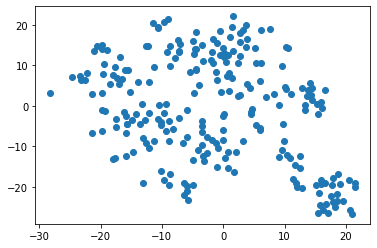

In [349]:
plt.scatter([x[0] for x in mini_embed],[x[1] for x in mini_embed])

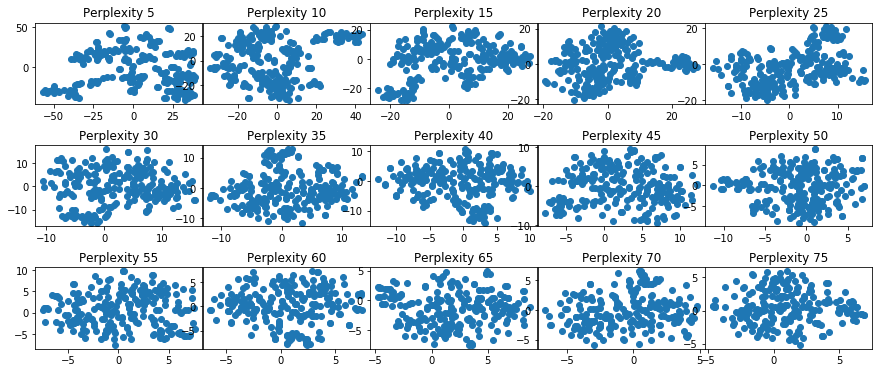

In [350]:
fig, axs = plt.subplots(3,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(1, 16):

    mini_embed_ = TSNE(perplexity=(i*5)).fit_transform(df_tsne_mini)
    axs[i-1].scatter([x[0] for x in mini_embed_],[x[1] for x in mini_embed_])
    axs[i-1].set_title(f'Perplexity {i*5}')

In [354]:
tsne_40 = df_tsne.loc[::5, 'minplayers':'Role Playing']

In [355]:
tsne_test = TSNE(perplexity=40)

In [356]:
embed = tsne_test.fit_transform(tsne_40)

In [357]:
names = [x for x in df_tsne['details.name']]
X = [x[0] for x in embed]
Y = [x[1] for x in embed]

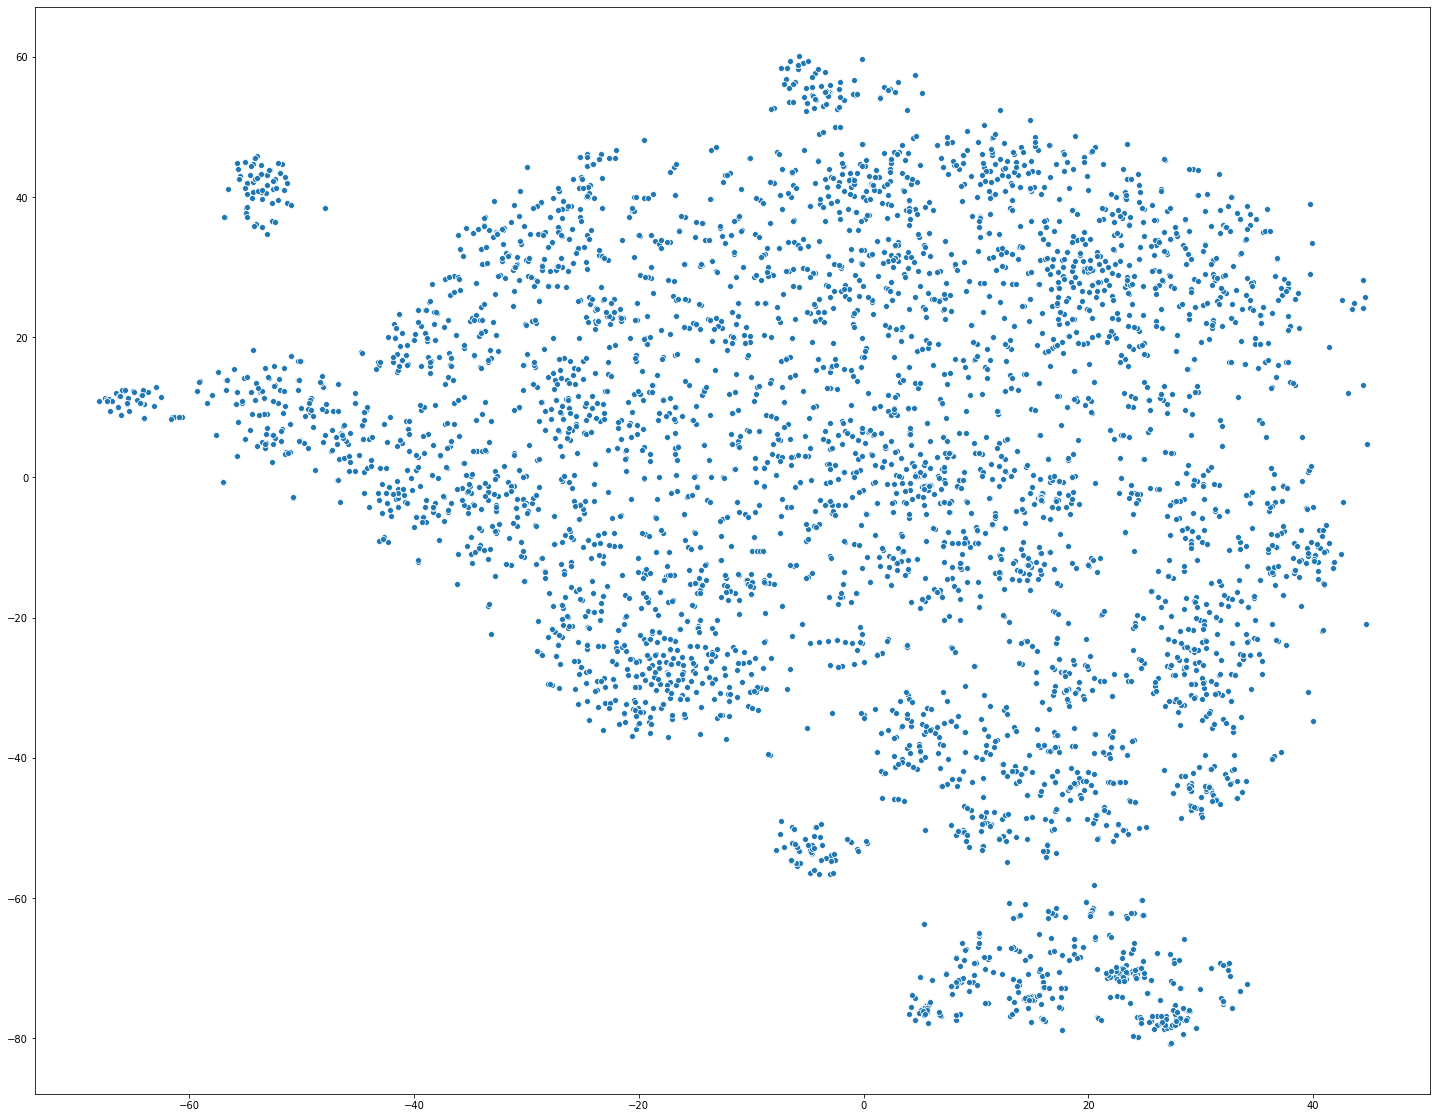

In [358]:
plt.figure(figsize = (25,20))
sns.scatterplot(X, Y)

# for i,name in enumerate(names):
#     plt.text(X[i], Y[i], name, fontsize=9)
plt.show();

In [359]:
x_min = [x[0] for x in mini_embed]
y_min = [x[1] for x in mini_embed]

/Users/flatiron-school/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 35851 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/flatiron-school/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26432 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/flatiron-school/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 27861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/flatiron-school/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21017 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/flatiron-school/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 65306 miss

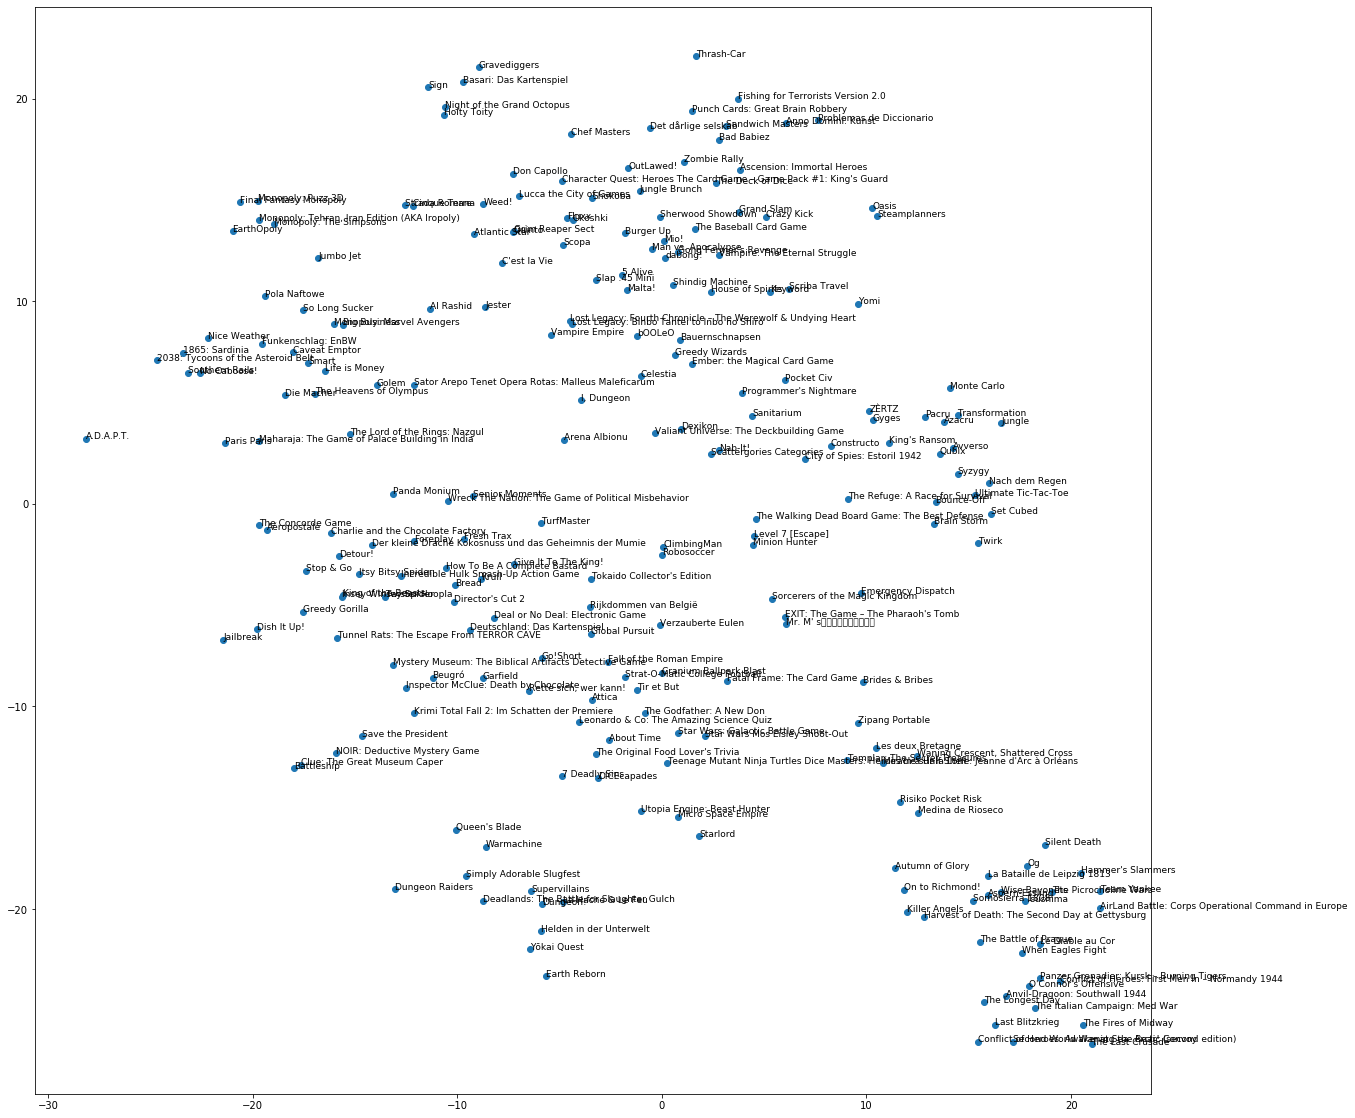

In [360]:
plt.figure(figsize=(20,20))
plt.scatter(x_min, y_min)

for i,name in enumerate(names[::100]):
    plt.text(x_min[i], y_min[i], name, fontsize=9)
plt.show()

In [361]:
# Need both loc and iloc as loc uses the index value

df_tsne_top = df_tsne.sort_values(by='bayes_average_rating', ascending=False)
names_top = [x for x in df_tsne_top['details.name']]
df_tsne_top = df_tsne_top.drop(columns=['users_rated', 'average_rating', 'bayes_average_rating', 'total_weights', 'None']).iloc[:400].loc[:, 'minplayers':'Role Playing']

In [362]:
df_tsne_top.head()

,minplayers,maxplayers,playingtime,average_weight,Political,Mafia,Fighting,Action / Dexterity,Farming,Negotiation,American West,Memory,World War II,Economic,Horror,Real-time,American Revolutionary War,Racing,Korean War,Abstract Strategy,Modern Warfare,Vietnam War,Environmental,American Indian Wars,Number,Fantasy,Deduction,Civil War,Mature / Adult,Prehistoric,Card Game,Ancient,Miniatures,Educational,Collectible Components,Word Game,Science Fiction,Dice,World War I,Book,Adventure,Comic Book / Strip,Trivia,Music,Puzzle,Expansion for Base-game,Sports,Transportation,American Civil War,Zombies,Napoleonic,Aviation / Flight,Age of Reason,Video Game Theme,Arabian,Bluffing,Post-Napoleonic,Fan Expansion,Medieval,City Building,Territory Building,Civilization,Religious,Exploration,Pirates,Electronic,Murder/Mystery,Mythology,Game System,Travel,Wargame,Space Exploration,Industry / Manufacturing,Humor,Novel-based,Movies / TV / Radio theme,Party Game,Children's Game,Pike and Shot,Math,Trains,Medical,Spies/Secret Agents,Animals,Nautical,Renaissance,Maze,Print & Play,Rock-Paper-Scissors,Simultaneous Action Selection,Area-Impulse,Area Movement,Betting/Wagering,Card Drafting,Stock Holding,Hand Management,Campaign / Battle Card Driven,Time Track,Variable Phase Order,Trading,Co-operative Play,Simulation,Take That,Action Point Allowance System,Auction/Bidding,Area Enclosure,Pattern Recognition,Press Your Luck,Hex-and-Counter,Trick-taking,Grid Movement,Acting,Route/Network Building,Paper-and-Pencil,Singing,Action / Movement Programming,Roll / Spin and Move,Player Elimination,Secret Unit Deployment,Partnerships,Voting,Set Collection,Variable Player Powers,Dice Rolling,Point to Point Movement,Deck / Pool Building,Tile Placement,Area Control / Area Influence,Storytelling,Pattern Building,Pick-up and Deliver,Crayon Rail System,Chit-Pull System,Modular Board,Worker Placement,Line Drawing,Commodity Speculation,Role Playing
21043,0.066667,0.04,0.2,0.76136,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
20019,0.133333,0.04,0.1,0.56626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
20480,0.066667,0.05,0.2,0.64652,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
21680,0.133333,0.04,0.2,0.87672,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23086,0.133333,0.04,0.2,0.78214,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [363]:
top_embed = TSNE(perplexity=14, n_iter=8000, learning_rate=200, random_state=137, init='pca').fit_transform(df_tsne_top)

In [364]:
x_top = [x[0] for x in top_embed]
y_top = [x[1] for x in top_embed]

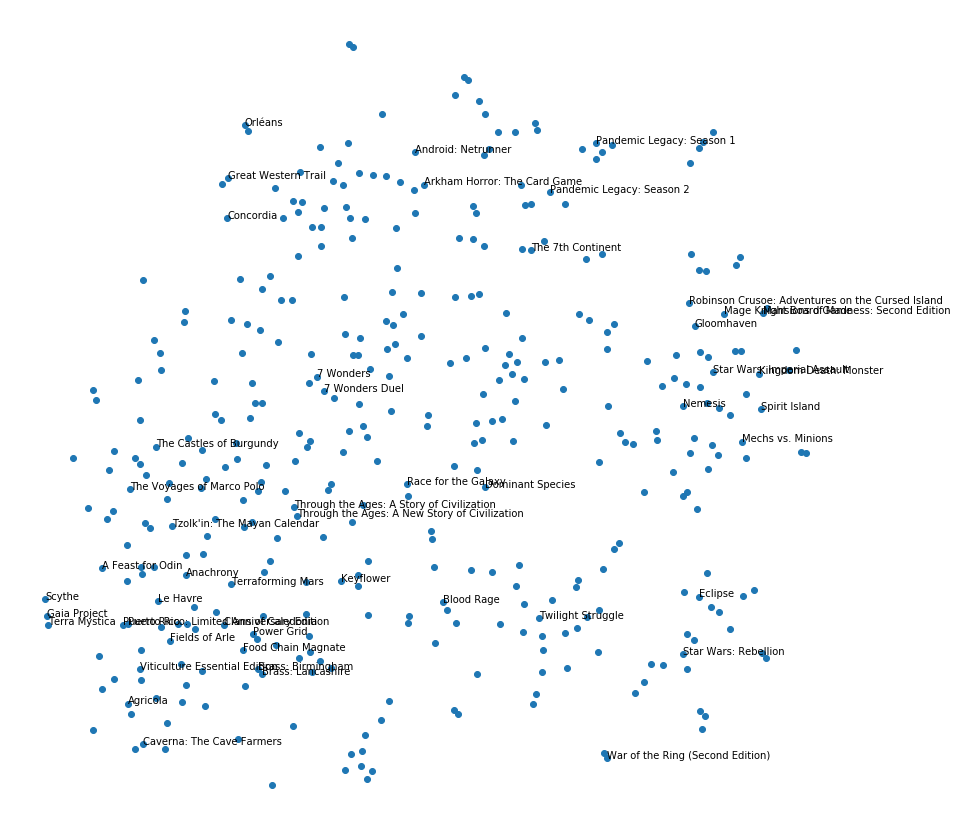

In [365]:
plt.figure(figsize=(15,15))
plt.scatter(x_top, y_top)

for i,name in enumerate(names_top[:50]):
    plt.text(x_top[i], y_top[i], name, fontsize=10)
plt.axis('off')
plt.show()

In [366]:
tsne_all = TSNE(perplexity=50, n_components=2, n_iter=8000, init='pca', random_state=137)

In [367]:
# Sorting by bayes average here to help labeling

df_tsne_all = df_tsne.sort_values(by='bayes_average_rating', ascending=False).drop(columns=['users_rated',
                                                                                            'average_rating', 'bayes_average_rating', 
                                                                                            'total_weights', 'None']).loc[:, 'minplayers':'Role Playing']

In [383]:
df_tsne_all

,minplayers,maxplayers,playingtime,average_weight,Political,Mafia,Fighting,Action / Dexterity,Farming,Negotiation,American West,Memory,World War II,Economic,Horror,Real-time,American Revolutionary War,Racing,Korean War,Abstract Strategy,Modern Warfare,Vietnam War,Environmental,American Indian Wars,Number,Fantasy,Deduction,Civil War,Mature / Adult,Prehistoric,Card Game,Ancient,Miniatures,Educational,Collectible Components,Word Game,Science Fiction,Dice,World War I,Book,Adventure,Comic Book / Strip,Trivia,Music,Puzzle,Expansion for Base-game,Sports,Transportation,American Civil War,Zombies,Napoleonic,Aviation / Flight,Age of Reason,Video Game Theme,Arabian,Bluffing,Post-Napoleonic,Fan Expansion,Medieval,City Building,Territory Building,Civilization,Religious,Exploration,Pirates,Electronic,Murder/Mystery,Mythology,Game System,Travel,Wargame,Space Exploration,Industry / Manufacturing,Humor,Novel-based,Movies / TV / Radio theme,Party Game,Children's Game,Pike and Shot,Math,Trains,Medical,Spies/Secret Agents,Animals,Nautical,Renaissance,Maze,Print & Play,Rock-Paper-Scissors,Simultaneous Action Selection,Area-Impulse,Area Movement,Betting/Wagering,Card Drafting,Stock Holding,Hand Management,Campaign / Battle Card Driven,Time Track,Variable Phase Order,Trading,Co-operative Play,Simulation,Take That,Action Point Allowance System,Auction/Bidding,Area Enclosure,Pattern Recognition,Press Your Luck,Hex-and-Counter,Trick-taking,Grid Movement,Acting,Route/Network Building,Paper-and-Pencil,Singing,Action / Movement Programming,Roll / Spin and Move,Player Elimination,Secret Unit Deployment,Partnerships,Voting,Set Collection,Variable Player Powers,Dice Rolling,Point to Point Movement,Deck / Pool Building,Tile Placement,Area Control / Area Influence,Storytelling,Pattern Building,Pick-up and Deliver,Crayon Rail System,Chit-Pull System,Modular Board,Worker Placement,Line Drawing,Commodity Speculation,Role Playing
21043,0.066667,0.04,0.200000,0.76136,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
20019,0.133333,0.04,0.100000,0.56626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
20480,0.066667,0.05,0.200000,0.64652,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
21680,0.133333,0.04,0.200000,0.87672,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23086,0.133333,0.04,0.200000,0.78214,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [371]:
# Takes about 1 hour to run
embed_all = tsne_all.fit_transform(df_tsne_all)

In [372]:
X = [x[0] for x in embed_all]
Y = [x[1] for x in embed_all]

In [451]:
# Getting the index so we can label the top 50 games in our big t-SNE
# Not needed? As we've order the df before

index_top_50 = df_tsne.sort_values(by='bayes_average_rating', ascending=False)[:50].index.to_list()

In [473]:
names_top_50 = df_tsne.sort_values(by='bayes_average_rating', ascending=False)[:50]['details.name'].to_list()

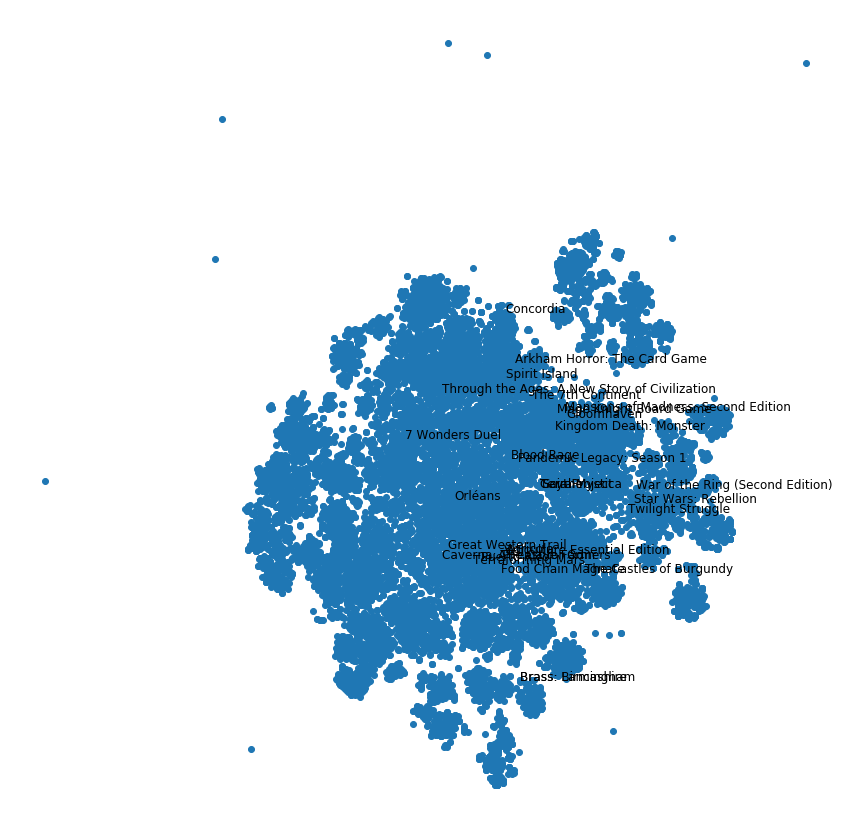

In [482]:
plt.figure(figsize=(15,15))
plt.scatter(X, Y)

for i in range(30):
    inx_x = X[i]
    inx_y = Y[i]
#     plt.scatter(inx_x, inx_y)
    plt.text(inx_x, inx_y, names_top_50[i], fontsize=12)

plt.axis('off')
plt.show()

In [523]:
# Let's try a t-SNE with no ratings
# And colour (based on ratings)!

In [527]:
bayes_rating = df_tsne['bayes_average_rating']

In [528]:
colour = cm.get_cmap('BuGn')

In [487]:
df_tsne_all_no_ratings = df_tsne.sort_values(by='bayes_average_rating', ascending=False).loc[:, 'Political':'Role Playing']
df_tsne_all_no_ratings.head(2)

,Political,Mafia,Fighting,Action / Dexterity,Farming,Negotiation,American West,Memory,World War II,Economic,Horror,Real-time,American Revolutionary War,Racing,Korean War,Abstract Strategy,Modern Warfare,Vietnam War,Environmental,American Indian Wars,Number,Fantasy,Deduction,Civil War,Mature / Adult,Prehistoric,Card Game,Ancient,Miniatures,Educational,Collectible Components,Word Game,Science Fiction,Dice,World War I,Book,Adventure,Comic Book / Strip,Trivia,Music,Puzzle,Expansion for Base-game,Sports,Transportation,American Civil War,Zombies,Napoleonic,Aviation / Flight,Age of Reason,Video Game Theme,Arabian,Bluffing,Post-Napoleonic,Fan Expansion,Medieval,City Building,Territory Building,Civilization,Religious,Exploration,Pirates,Electronic,Murder/Mystery,Mythology,Game System,Travel,Wargame,Space Exploration,Industry / Manufacturing,Humor,Novel-based,Movies / TV / Radio theme,Party Game,Children's Game,Pike and Shot,Math,Trains,Medical,Spies/Secret Agents,Animals,Nautical,Renaissance,Maze,Print & Play,Rock-Paper-Scissors,Simultaneous Action Selection,Area-Impulse,Area Movement,Betting/Wagering,Card Drafting,None,Stock Holding,Hand Management,Campaign / Battle Card Driven,Time Track,Variable Phase Order,Trading,Co-operative Play,Simulation,Take That,Action Point Allowance System,Auction/Bidding,Area Enclosure,Pattern Recognition,Press Your Luck,Hex-and-Counter,Trick-taking,Grid Movement,Acting,Route/Network Building,Paper-and-Pencil,Singing,Action / Movement Programming,Roll / Spin and Move,Player Elimination,Secret Unit Deployment,Partnerships,Voting,Set Collection,Variable Player Powers,Dice Rolling,Point to Point Movement,Deck / Pool Building,Tile Placement,Area Control / Area Influence,Storytelling,Pattern Building,Pick-up and Deliver,Crayon Rail System,Chit-Pull System,Modular Board,Worker Placement,Line Drawing,Commodity Speculation,Role Playing
21043,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
20019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [488]:
tsne_all_no_ratings = TSNE(perplexity=50, n_components=2, n_iter=8000, init='pca', random_state=137)

In [489]:
embed_no_ratings = tsne_all_no_ratings.fit_transform(df_tsne_all_no_ratings)

In [536]:
X = [x[0] for x in embed_no_ratings]
Y = [x[1] for x in embed_no_ratings]

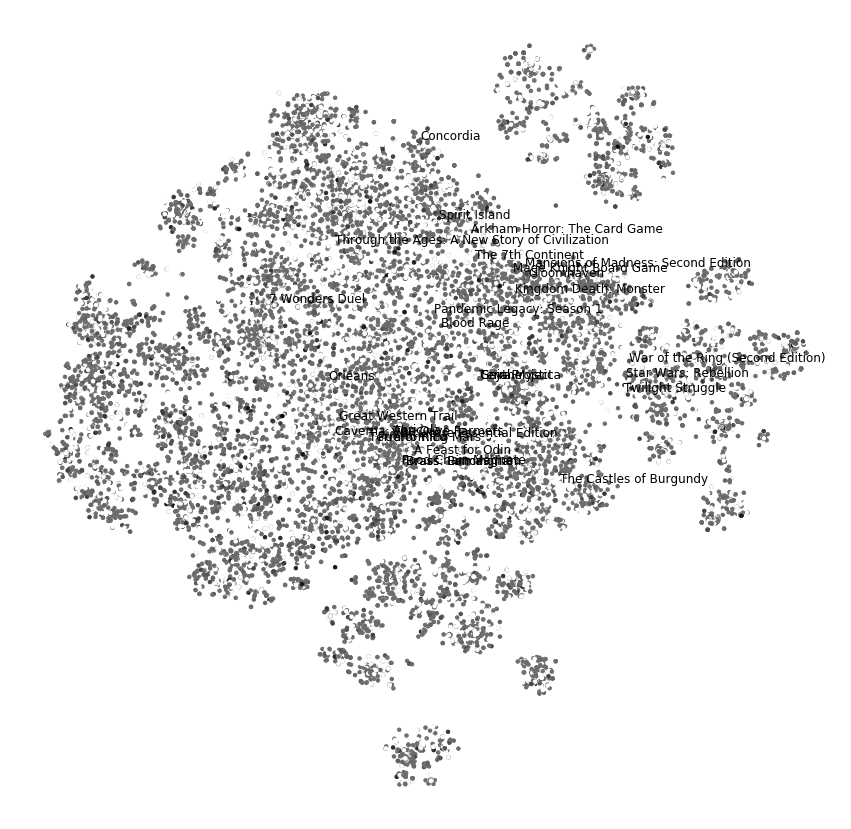

In [555]:
plt.figure(figsize=(15,15))
plt.scatter(X, Y, s=12, c=bayes_rating, cmap=cm.get_cmap('Greys'))

for i in range(30):
    inx_x = X[i]
    inx_y = Y[i]
#     plt.scatter(inx_x, inx_y)
    plt.text(inx_x, inx_y, names_top_50[i], fontsize=12)

plt.axis('off')
plt.show()

In [506]:
# t-SNE perhaps impossible using this many data points, should be  < 10 000

In [501]:
tsne_all_no_ratings_2 = TSNE(perplexity=30, n_components=2, n_iter=12000, init='pca', random_state=137)

In [503]:
embed_no_ratings_2 = tsne_all_no_ratings_2.fit_transform(df_tsne_all_no_ratings)

In [504]:
X = [x[0] for x in embed_no_ratings_2]
Y = [x[1] for x in embed_no_ratings_2]

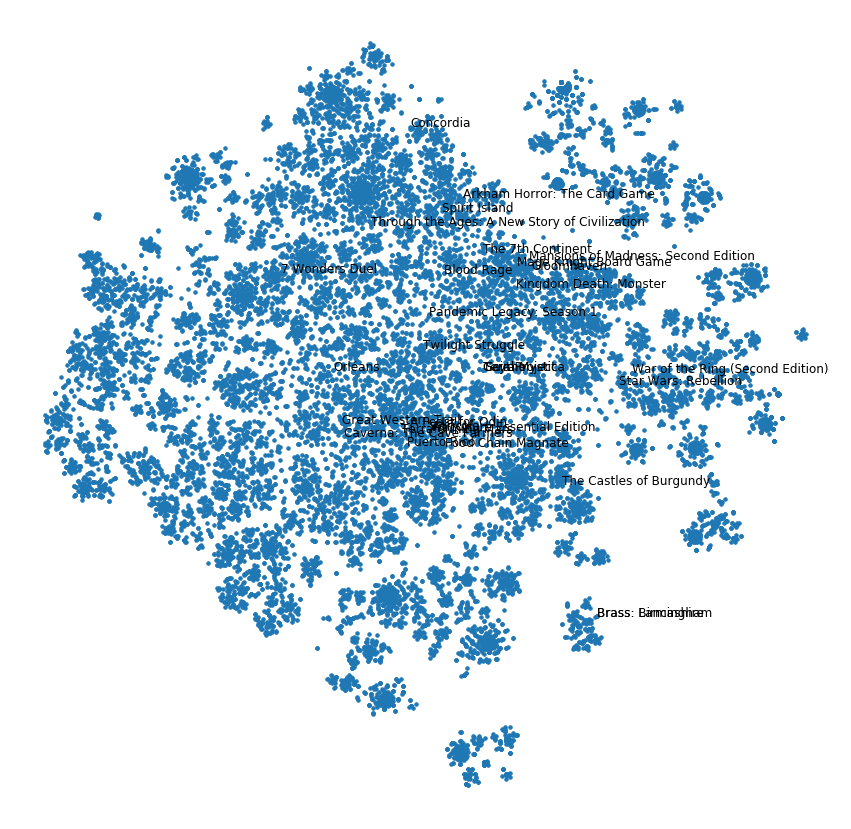

In [505]:
plt.figure(figsize=(15,15))
plt.scatter(X, Y, s=12)

for i in range(30):
    inx_x = X[i]
    inx_y = Y[i]
#     plt.scatter(inx_x, inx_y)
    plt.text(inx_x, inx_y, names_top_50[i], fontsize=12)

plt.axis('off')
plt.show()

In [507]:
tsne_all_no_ratings_3 = TSNE(perplexity=15, n_components=2, n_iter=12000, init='pca', random_state=137)

In [508]:
embed_no_ratings_3 = tsne_all_no_ratings_3.fit_transform(df_tsne_all_no_ratings)

In [509]:
X = [x[0] for x in embed_no_ratings_3]
Y = [x[1] for x in embed_no_ratings_3]

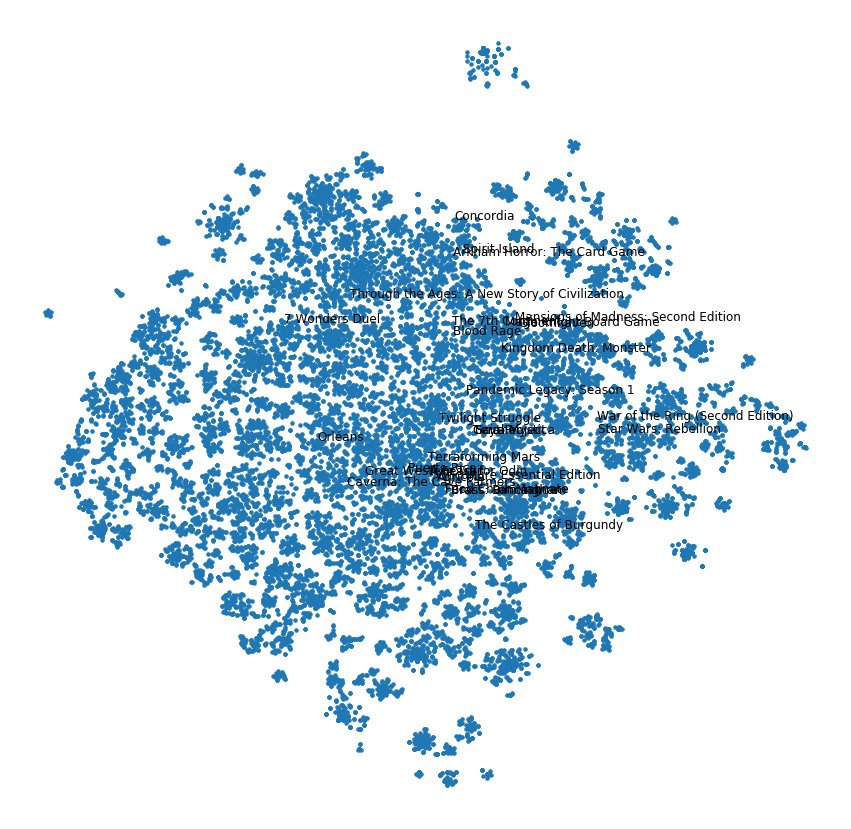

In [510]:
plt.figure(figsize=(15,15))
plt.scatter(X, Y, s=12)

for i in range(30):
    inx_x = X[i]
    inx_y = Y[i]
#     plt.scatter(inx_x, inx_y)
    plt.text(inx_x, inx_y, names_top_50[i], fontsize=12)

plt.axis('off')
plt.show()

In [511]:
tsne_all_no_ratings_4 = TSNE(perplexity=200, n_components=2, n_iter=12000, init='pca', random_state=137)

In [512]:
embed_no_ratings_4 = tsne_all_no_ratings_4.fit_transform(df_tsne_all_no_ratings)

In [513]:
X = [x[0] for x in embed_no_ratings_4]
Y = [x[1] for x in embed_no_ratings_4]

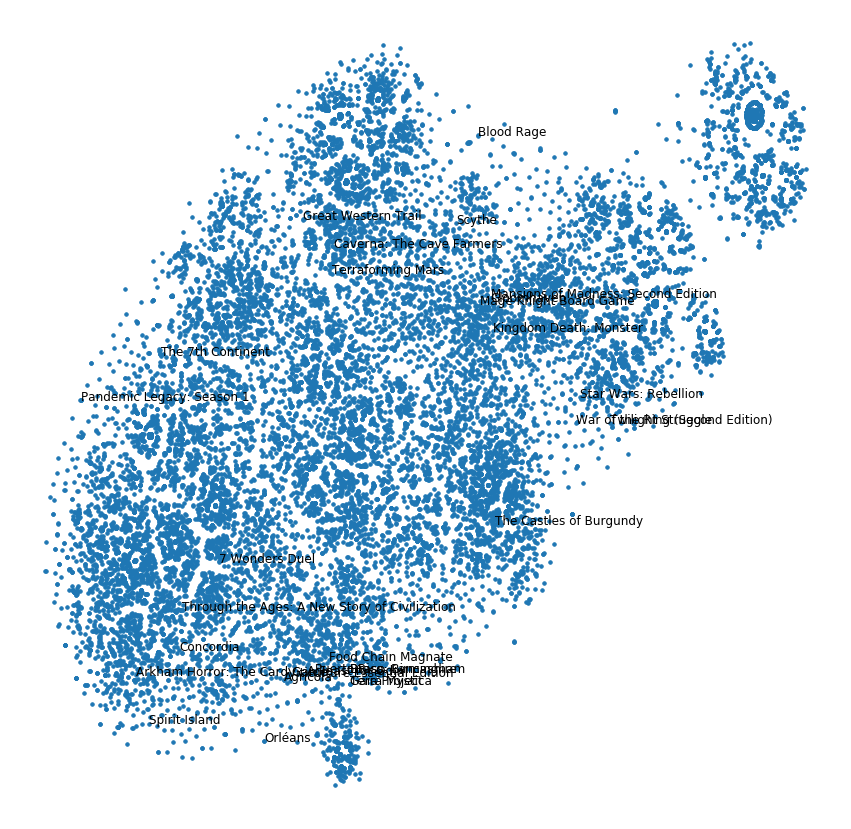

In [520]:
plt.figure(figsize=(15,15))
plt.scatter(X, Y, s=12)

for i in range(30):
    inx_x = X[i]
    inx_y = Y[i]
#     plt.scatter(inx_x, inx_y)
    plt.text(inx_x, inx_y, names_top_50[i], fontsize=12)

plt.axis('off')
plt.show()

In [515]:
tsne_all_no_ratings_5 = TSNE(perplexity=500, n_components=2, n_iter=12000, init='pca', random_state=137)

In [516]:
embed_no_ratings_5 = tsne_all_no_ratings_5.fit_transform(df_tsne_all_no_ratings)

In [517]:
X = [x[0] for x in embed_no_ratings_5]
Y = [x[1] for x in embed_no_ratings_5]

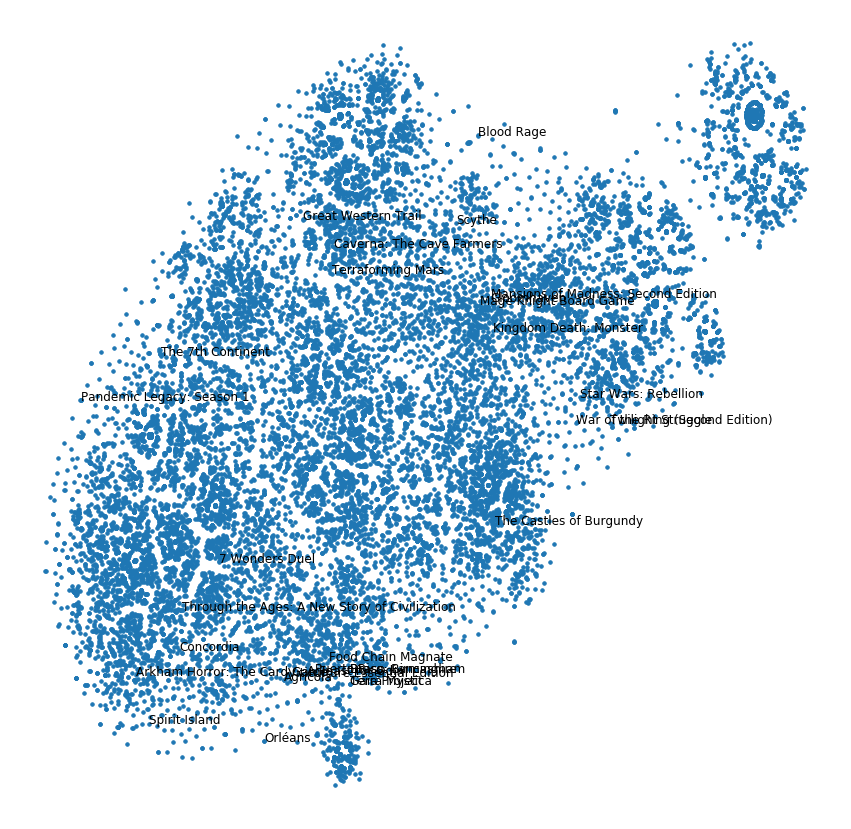

In [518]:
plt.figure(figsize=(15,15))
plt.scatter(X, Y, s=12)

for i in range(30):
    inx_x = X[i]
    inx_y = Y[i]
#     plt.scatter(inx_x, inx_y)
    plt.text(inx_x, inx_y, names_top_50[i], fontsize=12)

plt.axis('off')
plt.show()

In [612]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)

In [613]:
clusterer.fit(embed_no_ratings_5[:1000])

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [614]:
clusterer.labels_.max()

46

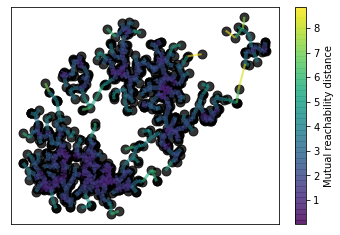

In [615]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2);

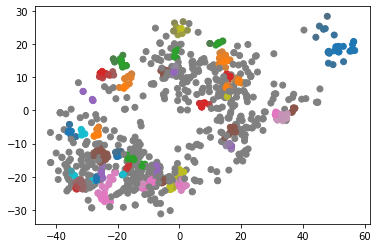

In [619]:
palette = sns.color_palette(n_colors=len(clusterer.labels_))

cluster_colors = [sns.desaturate(palette[col], sat) if col >= 0 else (0.5, 0.5, 0.5) for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]

plt.scatter(embed_no_ratings_5[:1000].T[0], embed_no_ratings_5[:1000].T[1], c=cluster_colors);

In [620]:
# Dropping the non-mechanic/category data seemed to help, we'll now look at the top (most popular) 1000 games and perform t-SNE + clustering

In [625]:
df_tsne_top_no_ratings = df_tsne.sort_values(by='bayes_average_rating', ascending=False).loc[:, 'Political':'Role Playing'][:1000]

In [633]:
df_tsne_top_no_ratings.shape

(1000, 135)

In [690]:
tsne_top_1000 = TSNE(perplexity=45, n_components=2, init='pca', n_iter= 8000, random_state=137)

In [691]:
top_1000_embedding = tsne_top_1000.fit_transform(df_tsne_top_no_ratings)

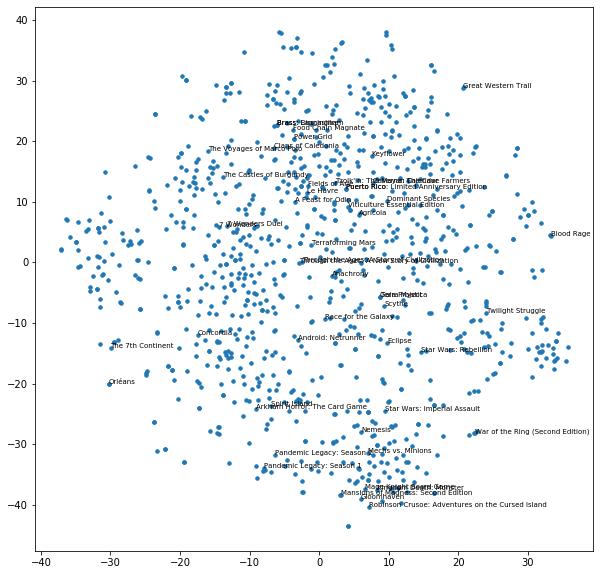

In [801]:
# This starred notation is equivalent to top_1000_embedding[:].T[0], top_1000_embedding[:].T[1] as the star unpacks each element

plt.figure(figsize=(10,10))
plt.scatter(*top_1000_embedding.T, s=12)

for i in range(50):
    inx_x = top_1000_embedding[i].T[0]
    inx_y = top_1000_embedding[i].T[1]
#     plt.scatter(inx_x, inx_y)
    plt.text(inx_x, inx_y, names_top_50[i], fontsize=7)

# plt.axis('off')
plt.show()

In [789]:
clusterer_1000 = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)

In [790]:
clusterer_1000.fit(top_1000_embedding)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [791]:
clusterer_1000.labels_.max()

27

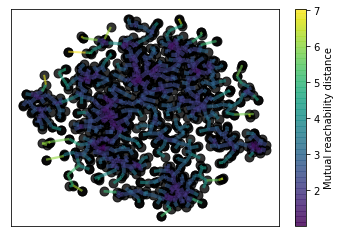

In [792]:
clusterer_1000.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2);

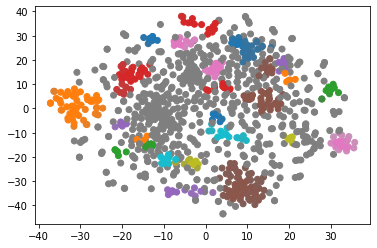

In [793]:
palette = sns.color_palette(n_colors=len(clusterer_1000.labels_))

cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) 
                  for col, sat in zip(clusterer_1000.labels_, clusterer_1000.probabilities_)]

plt.scatter(top_1000_embedding[:].T[0], top_1000_embedding[:].T[1], c=cluster_colors);

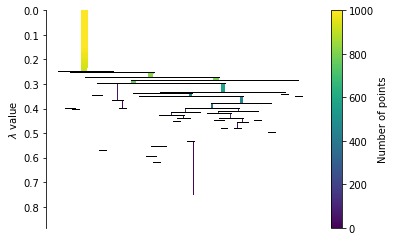

In [800]:
clusterer_1000.condensed_tree_.plot();

In [794]:
# Adding 2 so we can loop properly
top_labels = list(zip(names_top[:1000],clusterer_1000.labels_+2));

In [795]:
    for name, cat in top_labels:
        if cat == 1:
            cat_min_1.append(name)

In [796]:
# Adding three as we need to go up to the last label
cluster_dict = {}
for label in range(1, clusterer_1000.labels_.max() + 3):
    name_lst = []
    for name, cat in top_labels:
        if cat == label:
            name_lst.append(name)
    cluster_dict[label] = name_lst

In [798]:
cluster_dict[2]

['Ticket to Ride: 10th Anniversary',
 'Ticket to Ride: Europe',
 'Ticket to Ride: Nordic Countries',
 'Ticket to Ride',
 'Ticket to Ride: Märklin',
 'First Class: All Aboard the Orient Express',
 'Thurn and Taxis',
 'Ticket to Ride: Rails & Sails',
 'Elfenland']